In [11]:
import cvxpy as cp
from scipy.special import roots_sh_legendre
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class Word:
    def __init__(self, word: str):
        self._word = word
    def __repr__(self):
        return repr(self._word)
    def H(self):
        return Word(self._word[::-1])
    def __hash__(self):
        return hash(self._word)
    def __eq__(self, other):
        if not isinstance(other, Word):
            return False
        return self._word == other._word

class TraceOp:
    def __init__(self, word: Word):
        self._word = word
        self._expval = cp.Variable(1, str(self._word), complex=True)
    def __hash__(self):
        return hash(self._word)
    def ev(self):
        return self._expval
    def conjev(self):
        return cp.conj(self._expval)
    def __eq__(self, other):
        if not isinstance(other, TraceOp):
            return False
        return self._word == other._word

TOcache = dict()

def trace_op(word: Word):
    if word not in TOcache:
        TOcache[word] = TraceOp(word)
    return TOcache[word]

def commutator(word1: str, word2: str):
    expression = []
    for i in range(len(word1)):
        for j in range(len(word2)):
            # 1 2 2 1
            word = word1[:i] + word2[:j] + word2[j+1:] + word1[i+1:]
            if word1[i] == 'x' and word2[j] == 'p':
                expression.append('+' + word)
            elif word1[i] == 'p' and word2[j] == 'x':
                expression.append('-' + word)
    return expression

# def commutator(word1: str, word2: str):
#     return ['+' + word1 + word2, '-' + word2 + word1]

In [57]:
commutator('xxx','ppp')

['+ppxx',
 '+ppxx',
 '+ppxx',
 '+xppx',
 '+xppx',
 '+xppx',
 '+xxpp',
 '+xxpp',
 '+xxpp']

<h2>Thermal anharmonic oscillator:</h2>

In [13]:
def canonical_relation(word1: str, word2: str):
    t1 = Word(word1 + 'xp' + word2)
    t2 = Word(word1 + 'px' + word2)
    t3 = Word(word1 + word2)
    return [trace_op(t1).ev() - trace_op(t2).ev() == 1j * trace_op(t3).ev()]

hamil = [(1, 'pp'), (1, 'xxxx')]

def schwinger_dyson(word1: str):
    expression = 0
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for term in terms:
            if term[0] == '+':
                expression = expression + coeff * trace_op(Word(term[1:])).ev()
            else:
                expression = expression - coeff * trace_op(Word(term[1:])).ev()
    return [expression == 0]

def normalization():
    return [trace_op(Word('')).ev() == 1]

def reality(word: str):
    return [trace_op(Word(word[::-1])).ev() == trace_op(Word(word)).conjev()]

def thermal_density_matrix(op_basis, L):
    ops = [op
           for i in range(L//2 + 1)
           for op in op_basis[i]]
    n = len(ops)
    M = cp.bmat([[trace_op(Word(ops[i][::-1] + ops[j])).ev() for j in range(n)] for i in range(n)])
    return [M >> 0]

In [14]:
def A_matrix(ops):
    n = len(ops)
    A = cp.bmat([[trace_op(Word(ops[i][::-1] + ops[j])).ev() for j in range(n)] for i in range(n)])
    return A

def B_matrix(ops):
    n = len(ops)
    B = cp.bmat([[trace_op(Word(ops[j] + ops[i][::-1])).ev() for j in range(n)] for i in range(n)])
    return B

def C_matrix(ops):
    n = len(ops)
    def get_term(i,j):
        expression = 0
        for coeff, w in hamil:
            terms = commutator(w, ops[j])
            for term in terms:
                if term[0] == '+':
                    expression = expression + coeff * trace_op(Word(ops[i][::-1] + term[1:])).ev()
                else:
                    expression = expression - coeff * trace_op(Word(ops[i][::-1] + term[1:])).ev()
        return 1j * expression
    C = cp.bmat([[get_term(i,j) for j in range(n)] for i in range(n)])
    return C

def kms_condition(op_basis, L, m, k, beta):
    ops = [op
           for i in range(L//2 - 1)
           for op in op_basis[i]]
    n = len(ops)
    constraints = []
    A = A_matrix(ops)
    B = B_matrix(ops)
    C = C_matrix(ops)
    Ts = [cp.Variable((n,n),f'T_{i}',hermitian=True) for i in range(1, m + 1)]
    Zs = [cp.Variable((n,n),f'Z_{i}',hermitian=True) for i in range(0, k + 1)]
    constraints.append(Zs[0] == B)
    ts, ws = roots_sh_legendre(m)
    constraints.append(sum(wj * Tj for wj,Tj in zip(ws, Ts)) == -2**(-k) * beta * C)
    for i in range(k):
        constraints.append(cp.bmat([[Zs[i], Zs[i+1]],
                                    [Zs[i+1], A]]) >> 0)
    for j in range(m):
        constraints.append(cp.bmat([[Zs[k] - A - Ts[j], -np.sqrt(ts[j]) * Ts[j]],
                                    [-np.sqrt(ts[j]) * Ts[j], A - ts[j] * Ts[j]]]) >> 0)
    return constraints

In [15]:
from itertools import product
L = 10
m, k = 2, 2
beta = 2
op_basis = [[] for _ in range(L + 1)]
basis = ['x','p']
for l,v in enumerate(op_basis):
    v.extend(''.join(s) for s in product(basis,repeat=l))

In [23]:
constraints = []
constraints.extend(thermal_density_matrix(op_basis, L))
constraints.extend(normalization())
constraints.extend(kms_condition(op_basis, L, m, k, beta))
ops_Lm2 = [op
           for i in range(L - 1)
           for op in op_basis[i]]
for op1 in ops_Lm2:
    for op2 in ops_Lm2:
        if len(op1 + op2) > L - 2:
            continue
        constraints.extend(canonical_relation(op1,op2))
for op in ops_Lm2:
    expression = schwinger_dyson(op)
    if isinstance(expression, bool):
        continue
    constraints.extend(expression)
for op_L in op_basis:
    for word in op_L:
        constraints.extend(reality(word))

In [24]:
minobj = cp.Minimize(cp.real(trace_op(Word('pp')).ev() + trace_op(Word('xxxx')).ev()))
maxobj = cp.Maximize(cp.real(trace_op(Word('pp')).ev() + trace_op(Word('xxxx')).ev()))
minprob = cp.Problem(minobj, constraints)
maxprob = cp.Problem(maxobj, constraints)

In [25]:
minprob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 15 07:46:28 PM: Your problem has 3172 variables, 14675 constraints, and 0 parameters.
(CVXPY) Oct 15 07:46:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 15 07:46:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 15 07:46:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 15 07:46:29 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 15 07:46:30 PM: Compiling problem (target solver=MOSEK

/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


(CVXPY) Oct 15 07:46:38 PM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 15 07:46:41 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 15 07:46:49 PM: Applying reduction MOSEK
(CVXPY) Oct 15 07:46:55 PM: Finished problem compilation (took 2.593e+01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 15 07:46:55 PM: Invoking solver MOSEK  to obtain a solution.


(CVXPY) Oct 15 07:46:55 PM: Problem
(CVXPY) Oct 15 07:46:55 PM:   Name                   :                 
(CVXPY) Oct 15 07:46:55 PM:   Objective sense        : maximize        
(CVXPY) Oct 15 07:46:55 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Oct 15 07:46:55 PM:   Constraints            : 5219            
(CVXPY) Oct 15 07:46:55 PM:   Affine conic cons.     : 0               
(CVXPY)

1.0705984124353616

In [31]:
def create_constraints(op_basis, L, m, k, beta):
    constraints = []
    constraints.extend(thermal_density_matrix(op_basis, L))
    constraints.extend(normalization())
    constraints.extend(kms_condition(op_basis, L, m, k, beta))
    ops_Lm2 = [op
            for i in range(L - 1)
            for op in op_basis[i]]
    for op1 in ops_Lm2:
        for op2 in ops_Lm2:
            if len(op1 + op2) > L - 2:
                continue
            constraints.extend(canonical_relation(op1,op2))
    for op in ops_Lm2:
        expression = schwinger_dyson(op)
        if isinstance(expression, bool):
            continue
        constraints.extend(expression)
    for op_L in op_basis:
        for word in op_L:
            constraints.extend(reality(word))
    return constraints

In [32]:
betas = 1/np.linspace(0.1,0.6,num=6)
mins,maxs = [], []
for beta in betas:
    print(f'Solving for T = {1/beta}:\n')
    constraints = create_constraints(op_basis, L, m, k, beta)
    minobj = cp.Minimize(cp.real(trace_op(Word('pp')).ev() + trace_op(Word('xxxx')).ev()))
    maxobj = cp.Maximize(cp.real(trace_op(Word('pp')).ev() + trace_op(Word('xxxx')).ev()))
    minprob = cp.Problem(minobj, constraints)
    maxprob = cp.Problem(maxobj, constraints)
    minval = minprob.solve()
    print(f'\tE_min = {minval}\n')
    maxval = maxprob.solve()
    print(f'\tE_max = {maxval}\n')
    mins.append(minval)
    maxs.append(maxval)

Solving for T = 0.1:



/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


	E_min = 1.0603622129901589

	E_max = 1.0603622312487573

Solving for T = 0.2:

	E_min = 1.060362795565853

	E_max = 1.06036321639006

Solving for T = 0.30000000000000004:

	E_min = 1.0604466046372747

	E_max = 1.0604644094183173

Solving for T = 0.4:

	E_min = 1.0625294381925832

	E_max = 1.0627780478038806

Solving for T = 0.5:

	E_min = 1.0705984124353616

	E_max = 1.071535469686481

Solving for T = 0.6:

	E_min = 1.0872218533316644

	E_max = 1.0892648419175581



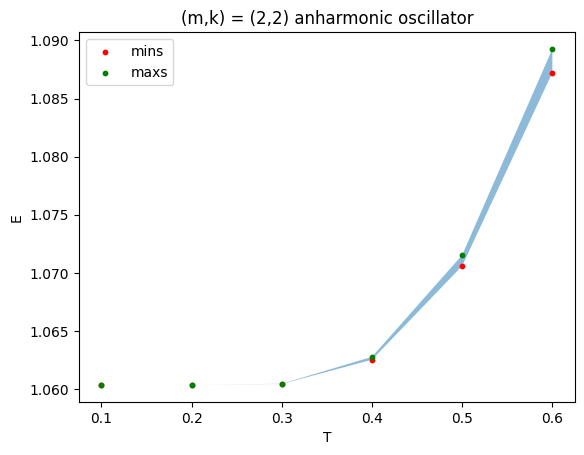

In [41]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5)
plt.scatter(1/betas, mins, c='red',label='mins',s=10)
plt.scatter(1/betas, maxs, c='green',label='maxs',s=10)
plt.xlabel('T')
plt.ylabel('E')
plt.title('(m,k) = (2,2) anharmonic oscillator')
plt.legend()
plt.show()